In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import time
import itertools
import wandb
import pickle
from cesium import featurize
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,confusion_matrix,recall_score,roc_curve,plot_roc_curve,make_scorer,average_precision_score,roc_auc_score,plot_precision_recall_curve,f1_score,plot_confusion_matrix
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from skopt import BayesSearchCV

## Fine-Tuning Hyperparameters on Sector 14 EB Data
In this notebook I am going to set up a few hyperparameter searches (probably using GridSearchCV(), RandomizedSearchCV(), or BayesSearchCV() (that last one is from scikit-optimize). This is to explore some promising regions of parameter space that I haven't checked out yet. I'll let the searches run in the background on this machine (aparsells-sweep) while I do other things on aparsells-test2. 

I don't think there's any reason to do this on the data that still has the long-period EBs in it since the performance only went up when I removed them. So let me start by reading in the data that has the long-period EBs removed. 

In [2]:
wandb.login()

wandb: Currently logged in as: parsellsx (use `wandb login --relogin` to force relogin)


True

In [3]:
# Read in final_input_df and fset for short-period data
final_input_df_short_period = pd.read_pickle('sector_14_final_input_df_short_period_8-2-21.zip')
fset_short_period = pd.read_pickle('sector_14_fset_short_period_8-2-21.zip')

In [4]:
# Split into train and test data
X_train_short_period, X_test_short_period, y_train_short_period, y_test_short_period = train_test_split(
    fset_short_period,final_input_df_short_period['label'],train_size=0.5,random_state=2)

In [6]:
# Check and make sure there's a reasonable balance of EBs to non-EBs in each - recall 1700 EBs total
np.where(y_test_short_period == 'EB')[0].size # 833/1700 in the test is reasonable

833

Fitting 5 folds for each of 300 candidates, totalling 1500 fits
Accuracy: 0.845945945945946
Precision: 0.9176829268292683
Recall: 0.7226890756302521
F1-score: 0.8085963734049698
AUC (ROC): 0.9031966769008488


accuracy,0.84595
precision,0.91768
recall,0.72269
f1_score,0.8086
auc,0.9032
_runtime,6
_timestamp,1628189292
_step,0


accuracy,▁
precision,▁
recall,▁
f1_score,▁
auc,▁
_runtime,▁
_timestamp,▁
_step,▁


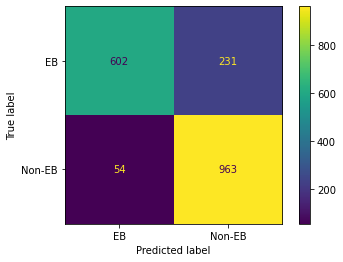

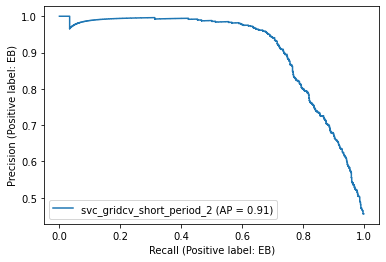

In [11]:
# SVC
pipeline = make_pipeline(StandardScaler(),svm.SVC(probability=True,random_state=11)) # prob=True for auc in func. 
# After looking at the accuracy for different hyperparameter combinations on the test-sweep-3 run of W&B (that was
# the one where I recorded every run for the SVC), looks like any value of C under 0.09 is probably a waste of
# time. But even up to 25 there are decent values, so I'll sample more in the 0.1 to 30 or so region
# kernel doesn't seem to be too influential
# gamma doesn't seem to be influential at all - I'm going to just stick to the default, which is 'scale'
# tol doesn't really seem to be influential at all, and that's supported by W&B's automatic "importance". I am
# going to keep the default parameter (1e-3), get rid of the rest, and add 2 new ones just to try them out
# I'm also going to add the 'degree' parameter, which only applies to the runs where kernel='poly'
# Also adding class_weight - trying both default (every class is weighted equally) or 'balanced' (weight them
# based on their frequency in the data)
# Don't forget to put all the same hyperparameters in all dictionaries in hypers
hypers = [{'svc__C':[0.1,0.5,1,2,3,5,8,10,25,30], # 1st grid
          'svc__kernel':['rbf','sigmoid'],
          'svc__degree':[3],
          'svc__gamma':['scale'],
          'svc__tol':[1e-5,1e-3,1e-1],
          'svc__class_weight':['balanced',None]},
          {'svc__C':[0.1,0.5,1,2,3,5,8,10,25,30], # 2nd grid
          'svc__kernel':['poly'],
          'svc__degree':[2,3,4],
          'svc__gamma':['scale'],
          'svc__tol':[1e-5,1e-3,1e-1],
          'svc__class_weight':['balanced',None]}]
cv_scoring = {'accuracy': make_scorer(accuracy_score),
              'precision': make_scorer(precision_score,pos_label='EB'),
              'recall': make_scorer(recall_score,pos_label='EB'),
              'auc': 'roc_auc'}
run_name = 'svc_gridcv_short_period_2'
# Actually do the run
grid_cv_with_wandb(pipeline,hypers,cv_scoring,run_name,X_train_short_period,X_test_short_period,
                   y_train_short_period,y_test_short_period) # Here refit = 'accuracy' (default)

In [ ]:
# Random forest - started 1:14 pm 8/5/21
pipeline = make_pipeline(StandardScaler(),RandomForestClassifier(n_jobs=-1,random_state=104))
rfc = 'randomforestclassifier__'
# Changing n_estimators to 1200 to explore a little more space - seems like more is generally better
# criterion I'm changing to just one option (the default; 'gini') because it seems to have no effect on accuracy
# max_depth I'm adding in 25 and getting rid of 3 and 5 based on performance
# min_samples_split I'm adding in a few more and getting rid of 50 (that was too many)
# max_features I'm adding in some numbers (these are integer numbers of features to look at). Got rid of 'sqrt'
# since that would be about 5 with the 29 features I'm using
# Added min_samples_leaf, class_weight with some values to try
hypers = [{rfc + 'n_estimators': [1200], # 1st grid
          rfc + 'criterion': ['gini'],
          rfc + 'max_depth': [10,25,50,None],
          rfc + 'min_samples_split': [2,5,7,10,15],
          rfc + 'max_features': [3,5,15,20,None],
          rfc + 'min_samples_leaf': [1,3,10,40],
          rfc + 'class_weight': ['balanced',None],
          rfc + 'ccp_alpha': [0,0.002,0.005,0.02],
          rfc + 'max_samples': [50,200,500,None],
          rfc + 'max_leaf_nodes': [5,10,None],
          rfc + 'bootstrap': [True]},
          {rfc + 'n_estimators': [1200], # 2nd grid
          rfc + 'criterion': ['gini'],
          rfc + 'max_depth': [10,25,50,None],
          rfc + 'min_samples_split': [2,5,7,10,15],
          rfc + 'max_features': [3,5,15,20,None],
          rfc + 'min_samples_leaf': [1,3,10,40],
          rfc + 'class_weight': ['balanced',None],
          rfc + 'ccp_alpha': [0,0.002,0.005,0.02],
          rfc + 'max_samples': [None], # When bootstrap=False, max_samples is irrelevant
          rfc + 'max_leaf_nodes': [5,10,None],
          rfc + 'bootstrap': [False]}]
cv_scoring = {'accuracy': make_scorer(accuracy_score),
              'precision': make_scorer(precision_score,pos_label='EB'),
              'recall': make_scorer(recall_score,pos_label='EB'),
              'auc': 'roc_auc'}
run_name = 'rf_gridcv_short_period_2'
# Actually do the run
grid_cv_with_wandb(pipeline,hypers,cv_scoring,run_name,X_train_short_period,X_test_short_period,
                   y_train_short_period,y_test_short_period) # Here refit = 'accuracy' (default)

Fitting 5 folds for each of 48000 candidates, totalling 240000 fits


In [ ]:
# K neighbors - need to tweak still
pipeline = make_pipeline(StandardScaler(),KNeighborsClassifier())
knc = 'kneighborsclassifier__'
hypers = {knc + 'n_neighbors': [1,2,3,5,10,20],
          knc + 'weights': ['uniform','distance'],
          knc + 'metric': ['minkowski','mahalanobis'],
          knc + 'p': [1,2,3]}
cv_scoring = {'accuracy': make_scorer(accuracy_score),
              'precision': make_scorer(precision_score,pos_label='EB'),
              'recall': make_scorer(recall_score,pos_label='EB'),
              'auc': 'roc_auc'}
run_name = 'kneigh_gridcv_short_period_1'
# Actually do the run
grid_cv_with_wandb(pipeline,hypers,cv_scoring,run_name,X_train_short_period,X_test_short_period,
                  y_train_short_period,y_test_short_period) # Again refit = 'accuracy'

### Function to Do the Model Fitting and Logging

In [10]:
# pipeline should be a pre-made pipeline like make_pipeline(StandardScaler(),svm.SVC(random_state=36))
# hypers should be a dictionary like {'svc__C':[0.001,0.009,0.01,0.09,1,5,10,25],...}
# cv_scoring should be a dict like {'accuracy': make_scorer(accuracy_score),...}. It's the dict of all the metrics
# I want sklearn to track for the purpose of evaluating model performance during the cross-validation
# refit is the metric I want GridSearchCV() to use to evaluate which model is the best and is 'accuracy' by 
# default. But I can also write a function that will take in cv_results_ and return the sum of mean accuracy + 
# mean precision + mean recall and specify that function, or I could specify 'auc' to use the area under the ROC
# curve
# Update 8/2/21: X_train, X_test, y_train, and y_test are the train and test data, just like they sound like. I am
# changing the function so that these now need to be passed in as arguments rather than having the function just
# use whatever global variables named X_train, X_test, etc. already exist. So previous calls to this function in
# this notebook might not work, but it can be easily remedied by adding those arguments in the call [end update]
# pos_label is the data label to be used as the "positive" one for the purposes of computing precision, recall, 
# f1, etc. It is "EB" by default but can be changed for the future when I want to use multiple variable types
# labels is all the data labels in the set - used for confusion matrix. Currently it is ['EB','Non-EB'] by default
# but can be changed
# run_name is for purposes of saving the confusion matrix and p-r curve plots - need a proper filename. For
# example, 'svc_gridcv_1'. Also used in the legend for the p-r curve plot and in saving the cv_results_ df
# df_directory is the directory in which I'll store the Pandas dataframes from CV (cv_results_)
# Update 8/5/21: Changed the saved name of the run in W&B to be run_name (previously run_name was saved as the
# group name in W&B) and made the group name another optional argument to this function that has default value 
# 'sector_14_ebs_short_period_only'
def grid_cv_with_wandb(pipeline,hypers,cv_scoring,run_name,X_train,X_test,y_train,y_test,refit='accuracy',
                       pos_label='EB',labels=['EB','Non-EB'],df_directory='sector_14_gridsearchcv_dfs',
                       group_name='sector_14_ebs_short_period_only'):
    grid = GridSearchCV(pipeline,hypers,scoring=cv_scoring,refit=refit,n_jobs=-1,verbose=1,error_score=0)
    grid.fit(X_train,np.ravel(y_train)) # np.ravel flattens the array and makes it play nice with .fit()
    y_pred = grid.predict(X_test) # Predict on the test dataset to evaluate performance of the best model
    grid_results_df = pd.DataFrame(grid.cv_results_) # Get pandas dataframe w/ CV summary (training/validation)
    grid_results_df.to_pickle(df_directory + '/' + run_name + '.zip')
    # Get scores on the test data
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred,pos_label=pos_label)
    recall = recall_score(y_test,y_pred,pos_label=pos_label)
    f1 = f1_score(y_test,y_pred,pos_label=pos_label)
    # roc_auc_score requires 'y_score', which apparently can be 'estimator.decision_function(X,y)' (according to 
    # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score)
    y_score = grid.predict_proba(X_test)[:,1] # Currently only good for binary case (2 classes, not more)
    auc = roc_auc_score(y_test,y_score)
    confusion_matrix_ = confusion_matrix(y_test,y_pred,labels=labels) # Add underscore to avoid assignment error
    print('Accuracy: ' + str(accuracy) + '\nPrecision: ' + str(precision) + '\nRecall: ' + str(recall) + 
          '\nF1-score: ' + str(f1) + '\nAUC (ROC): ' + str(auc))
    fig, ax = plt.subplots()
    confusion_matrix_plot = plot_confusion_matrix(grid,X_test,y_test,ax=ax,labels=labels)
    plt.savefig('sklearn_plots_for_wandb/' + run_name + '_confusion_matrix.png')
    fig, ax = plt.subplots()
    precision_recall_plot = plot_precision_recall_curve(grid,X_test,y_test,ax=ax,name=run_name,pos_label=pos_label)
    plt.savefig('sklearn_plots_for_wandb/' + run_name + '_precision_recall.png')
    # Get list of just the actual hyperparameters (without values) for use in generating W&B config
    # Update 8/5/21: hypers might be a list of dictionaries (see description of param_grid in GridSearchCV(), so
    # I'm adding in a check here - if it is a list, then make grid_hyperlist equal to hypers[0].keys()). Also, 
    # need to make sure that if I do pass in hypers as a list of dicts, every dict needs to have all the 
    # hyperparameters I'm varying, even if they're fixed to just one value in some of the dicts (grids). That's so
    # that config (below) catches all the hyperparameters to log to W&B
    if isinstance(hypers,list): # If hypers is a list
        grid_hyperlist = list(hypers[0].keys())
    else: # If it's not a list, it should be a dictionary
        grid_hyperlist = list(hypers.keys()) # These still have '[estimator_type]__' in front of them - remove this:
    double_underscore_index = grid_hyperlist[0].find('__') # Search 1st key in hypers
    if double_underscore_index == -1: # Meaning, there's no __ in the string, which would mean I forgot to add it
        raise Exception
    for i, el in enumerate(grid_hyperlist):
        new_el = el[double_underscore_index+2:] # +2 to account for the length of '__' itself
        grid_hyperlist[i] = new_el # Now grid_hyperlist should just have the hyperparams w/o the 'svc__' or similar
    config = {} # Will hold hyperparameters for best run in grid
    for param in grid_hyperlist:
        config[param] = grid.best_estimator_.steps[-1][-1].get_params()[param]
    # Log everything to Weights & Biases
    with wandb.init(project='tess',group=group_name,name=run_name,config=config):
        wandb.log({'accuracy': accuracy,
                   'precision': precision,
                   'recall': recall,
                   'f1_score': f1,
                   'auc': auc,
                   'confusion_matrix': confusion_matrix_,
                   'confusion_matrix_plot': wandb.Image('sklearn_plots_for_wandb/' + run_name + '_confusion_matrix.png'),
                   'precision_recall_plot': wandb.Image('sklearn_plots_for_wandb/' + run_name + '_precision_recall.png')})